## Table of contents
1. <a href="#item1">Introduction</a>
2. <a href="#item2">Objective</a>  
3. <a href="#item3">Data</a>  
4. <a href="#item4">Methodology</a>  


## 1. Introduction

This is the capstone project of the Applied Data Science Course from Coursera.                                                    In this project we had to think about an own problem that could be solved using data from internet sources as well as from the foursquare database.

Since I live in Stuttgart and the rents are pretty high in some areas in Stuttgart, I thought about looking into some characteristics that influence the rent. 

**Stakeholders**: This could also be interesting for city planners. The politician don't want the rents to soar in some areas, so nearly nobody can afford them. With this project, the city planners can see what makes the rents rise and can maybe take action if necessary.

## 2. Objective


The goal of this project is to figure out which circumstances have an big impact on the rent and which are just incidental.
Therefore we will look for online sources with data regarding the population and other relevant factors in the different areas.
The foursquare database will be used to get information about local venues. Statistical methods will then be used to find dependencies between the extracted features and the rent.

The final objective is a set of features, that mainly influence the rent.

## 3. Data

The data section will cover following:

**1. First we will get the current rents per square meter for each borough.**

**2. Second we will extract the postcodes together with coordiantes for each borough. **

**3. Third we will get some data offered by the city of Stuttgart about the differen boroughs**

**4. Then we will use the foursquare database to get the venues in the boroughs. We will try to cluster them so they can be used for the analysis later on.**



**1. Getting the rents**

The current rents for each borough are taken from following website: https://www.wohnungsboerse.net/mietspiegel-Stuttgart/972

To process it more easily, I put the data into an excel file.

In [1]:
import pandas as pd
import numpy as np

#read the excel file into a data frame
rents = pd.read_excel("Stg_rent_by_borough.xlsx", sheet_name = "Tabelle1")
# rename the rent column
rents.rename(columns = {"€ / m2":"rent (€/m²) "},inplace = True)
rents.head()

,Borough,rent (€/m²)
0,Bad Cannstatt,16.34
1,Birkach,14.87
2,Botnang,14.04
3,Degerloch,18.89
4,Dürrlewang,20.64


** 2. Getting the postcodes**

Next we need the postcodes for the different boroughs.
I'll extract them from the following website using webscraping: https://www.suche-postleitzahl.org/stuttgart-plz-70173-70629.608e

In [2]:
from bs4 import BeautifulSoup
import requests

#get the html code from the respective website
page = requests.get('https://www.suche-postleitzahl.org/stuttgart-plz-70173-70629.608e').text
#store the html file in the soup variable with the lxml parser
soup = BeautifulSoup(page, 'lxml')
# extract the section from the soup with the respective table
soup_part = soup.find('section', id='ortsteile')

In [3]:
# initialize an empty list for the headers of the data frame
columns_headers = []
# search for all entries in the first row of the table (the headings)
for tr in soup_part.find_all('tr')[0].find_all('th'):
    columns_headers.append(tr.text)
columns_headers

['Stadtteil', 'Postleitzahl']

In [4]:
# initialize two empty lists for the column values
values_column1 = []
values_column2 = []
# loop through the table to get all the entries for the columns
for td in soup_part.find_all('td')[::2]:
    values_column1.append(td.text.strip())
for td in soup_part.find_all('td')[1::2]:
    values_column2.append(td.text)    
  

In [5]:
# We have to switch "Stuttgart-Mitte" to just "Mitte" and so on, so it matches the names in the previous Data Frame
for i,val in enumerate(values_column1):
    if val.startswith('Stuttgart-'):
        val = val[10:]
        values_column1[i] = val

** 2. Getting the coordinates**

Apparently, they also have the coordinates saved on the website, so I'll extract those as well

In [6]:
# initialize two empty list for the longitude and latitude
values_column3 = []
values_column4 = []
# loop thorugh the tabel and get the coordiantes
for td in soup_part.find_all('td')[::2]:
    values_column3.append(td['data-lat'])                            
for td in soup_part.find_all('td')[::2]:
    values_column4.append(td['data-lon'])

#add the column names to the column_headers
columns_headers.append('latitude')
columns_headers.append('longitude')

#converting the extracted strings to float values
values_column3 = list(map(float,values_column3))
values_column4 = list(map(float,values_column4))

In [7]:
#create a data frame
df_values = np.array([values_column1,values_column2,values_column3, values_column4]).transpose()
postcodes = pd.DataFrame(data = df_values, columns = columns_headers)
#change german to english
postcodes.rename(columns = {"Stadtteil":"Borough","Postleitzahl":"Postcode"}, inplace = True)
postcodes.head()

,Borough,Postcode,latitude,longitude
0,Asemwald,70599,48.72498,9.19134
1,Bad Cannstatt,"70191, 70372, 70374, 70376, 70378",48.80322,9.21746
2,Bergheim,70499,48.80154954,9.08995271
3,Birkach,70599,48.7193,9.208
4,Botnang,70195,48.7789874,9.12889838


**3. Getting data about the boroughs**

Now I will extract some more Data. Following website provides an excel file with loads of statstics: https://statistik.stuttgart.de/statistiken/statistikatlas/atlas/atlas.html?indikator=i0&select=00

You also can find it in my repository: https://github.com/dennis31197/Coursera_Capstone/blob/master/Stg_statistics_borough.xlsx

In [8]:
statistics = pd.read_excel("Stg_statistics_borough.xlsx", sheet_name = "Tabelle1")
statistics.head()

,Borough,residents per km²,sport and leisure area (m²/resident),Average age,amount of non-german residents (%),amount of married residents (%),residents per household,living area per flat
0,Mitte,6473,16.6,38.7,32.1,30.6,1.52,72.7
1,Nord,4823,36.3,41.3,26.1,43.4,1.81,82.6
2,Ost,7718,18.7,41.3,28.4,41.0,1.73,73.5
3,Süd,9321,10.4,40.3,24.3,38.9,1.68,75.8
4,West,12729,4.5,40.4,20.7,36.0,1.63,75.7


In [9]:
df_merge1 = pd.merge(rents,postcodes, how = 'inner', on='Borough')
Bouroughs_S = pd.merge(df_merge1, statistics, how = 'inner', on = 'Borough')

#change to data type of the coordinates to floats
Bouroughs_S['longitude'] = Bouroughs_S['longitude'].astype(dtype='float64')
Bouroughs_S['latitude'] = Bouroughs_S['latitude'].astype(dtype='float64')

Bouroughs_S.head()

,Borough,rent (€/m²),Postcode,latitude,longitude,residents per km²,sport and leisure area (m²/resident),Average age,amount of non-german residents (%),amount of married residents (%),residents per household,living area per flat
0,Bad Cannstatt,16.34,"70191, 70372, 70374, 70376, 70378",48.803220,9.217460,5745,32.3,40.9,31.7,46.9,1.88,74.4
1,Birkach,14.87,70599,48.719300,9.208000,5945,14.0,43.1,19.6,44.7,1.86,78.8
2,Botnang,14.04,70195,48.778987,9.128898,6987,16.3,45.6,17.3,52.6,1.93,86.4
3,Degerloch,18.89,70597,48.746795,9.170746,4526,30.4,44.7,18.4,49.1,1.87,87.4
4,Feuerbach,14.81,"70192, 70469, 70499",48.811301,9.159111,5321,13.1,42.3,28.9,49.4,1.90,79.6


In [10]:
import folium

# create map of Stuttgart using latitude and longitude values
map_stuttgart = folium.Map(location=[values_column3[0], values_column4[0]], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Bouroughs_S['latitude'], Bouroughs_S['longitude'], Bouroughs_S['Borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_stuttgart)  
    
map_stuttgart

**4. Getting data from foursquare**

Now it's time to get some data from Foursquare, that could influence the rents.                                                       
Number of restaurants, parks, shooping location, tram stations.                                                                 Therefore, I let's get the top 150 venues in a radius of 3km around the coordinates for each bourough


In [11]:
from pandas.io.json import json_normalize
CLIENT_ID = 'WDZVSRMBUM4GRNNKUTSV0AWYLLMHLNHZUGZDIOE25V5MLE1F' 
CLIENT_SECRET = 'WD4NYWRDESXQLLL21JGE1NASVBZVMURHWRTEAPOP1LP5SJMK' 
VERSION = '20180604'
LIMIT = 150
radius = 3000

In [12]:
def venues_categories(venue_request):
    '''
    returns a list with the categories with all the venues of the json file
    '''
    #determine how many venues are in the file
    amount_venues = len(venue_request['response']['groups'][0]['items'])
    #initiate empty list
    category_list = []
    #loop through the file and append the short names of the category to the list
    for i in range(0,amount_venues):
        category_list.append(venue_request['response']['groups'][0]['items'][i]['venue']['categories'][0]['shortName'])
        
    return category_list

In [13]:
number_boroughs = len(Bouroughs_S['Borough'])
categories_list = []
for i in range(0, number_boroughs):
    # loop thourgh all the boroughs in our dataset and save latitude and longitude
    latitude = Bouroughs_S.loc[i,'latitude']
    longitude = Bouroughs_S.loc[i,'longitude']

    #get the url for the call
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        LIMIT)
    
    #make the call
    results = requests.get(url).json()
    
    #save the categories of the venues into a list, the index of the borough in our data frame is also the same index in this list
    categories_list.append(venues_categories(results))
    



## 4. Methodology

Now we can expolore the different categories of the venues in the different boroughs and try to cluster and condense them, so we can extract features, that can be used for our analysis.

### Exploratory Data Analysis

In [14]:
categories_list[19]

['Concert Hall',
 'Gastropub',
 'Hardware',
 'Museum',
 'Restaurant',
 'Lounge',
 'German',
 'Burgers',
 'Park',
 'Deli / Bodega',
 'German',
 'Soccer',
 'Hotel',
 'Racetrack',
 'Concert Hall',
 'Soccer Field',
 'Bakery',
 'Middle Eastern',
 'History Museum',
 'Restaurant',
 'Hotel',
 'Bakery',
 'Gym',
 'Hotel',
 'Vineyard',
 'Fried Chicken',
 'German',
 'Bakery',
 'Greek',
 'Pool',
 'Sporting Goods',
 'Wine Shop',
 'Pool',
 'Park',
 'German',
 'Pub',
 'German',
 'Grocery Store',
 'Italian',
 'Lounge',
 'Supermarket',
 'Museum',
 'Gym',
 'Sports Bar',
 'Event Space',
 'Schnitzel',
 'Hotel',
 'Supermarket',
 'Supermarket',
 'German',
 'Fried Chicken',
 'Hotel',
 'Stadium',
 'Hardware',
 'Fast Food',
 'Fast Food',
 'Chinese',
 'Harbor / Marina',
 'Supermarket',
 'Soccer Field',
 'Hotel',
 'Bakery',
 'Music Venue',
 'German Pop-Up Restaurant']

After looking into it, I want to extract the following features:                                                                 
Number of:
1. Restaurants
2. Sport Activities
3. Leisure Activities
4. Transport
5. Shopping   

in the boroughs

Therefore I will create a list with the most common category names that occur for these features

In [15]:
restaurants = "restaurants,german,greek,swabian,spanish,french,food & drink,japanese,african,korean,turkish,vietnamese,sushi,italien,beer garden,thai,chinese,burgers,mediterranean,steakhouse,fast food".split(",")
sports = "gym,athletics & sports,gym / fitness,climbing gym,soccer field,soccer,sports club".split(",")
leisure =  "garden,pool,park,history museum,art museum,castle,mountain,playground,zoo exhibit,forest,movie theater,garden center,theater,hookah bar,museum,zoo,café,pub,nightclub,concert hall,exhibit".split(",")
transport = "train station,metro,tram,bus station,bus stop".split(",")
shopping ="supermarket,grocery store,drugstore,bakery,mall".split(",")

In [16]:
# initialize some empty lists
number_restaurants = []
number_sports = []
number_leisure = []
number_transport = []
number_shopping = []

for i in range(0,number_boroughs):
    #initialize counters
    restaurant_count = 0
    sports_count = 0
    leisure_count = 0
    transport_count = 0
    shopping_count = 0
    
    #loop through all values for one borough and increase the counter if a venue falls into one of the features
    for j in range(0,len(categories_list[i])):
        if categories_list[i][j].lower() in restaurants:
            restaurant_count += 1 
        elif categories_list[i][j].lower() in sports:
            sports_count += 1
        elif categories_list[i][j].lower() in leisure:
            leisure_count += 1
        elif categories_list[i][j].lower() in transport:
            transport_count +=1
        elif categories_list[i][j].lower() in shopping:
            shopping_count +=1
        else: pass
    #fill the list with the counters              
    number_restaurants.append(restaurant_count)
    number_sports.append(sports_count)
    number_leisure.append(leisure_count)
    number_transport.append(transport_count)
    number_shopping.append(shopping_count)

    

In [17]:
#adding the newe data to our data frame
Bouroughs_S["number of restaurants"] = number_restaurants
Bouroughs_S["number of sports"] = number_sports
Bouroughs_S["number of leisure"] = number_leisure
Bouroughs_S["number of transport"] = number_transport
Bouroughs_S["number of shopping"] = number_shopping

In [18]:
Bouroughs_S.head()

,Borough,rent (€/m²),Postcode,latitude,longitude,residents per km²,sport and leisure area (m²/resident),Average age,amount of non-german residents (%),amount of married residents (%),residents per household,living area per flat,number of restaurants,number of sports,number of leisure,number of transport,number of shopping
0,Bad Cannstatt,16.34,"70191, 70372, 70374, 70376, 70378",48.803220,9.217460,5745,32.3,40.9,31.7,46.9,1.88,74.4,16,4,30,0,8
1,Birkach,14.87,70599,48.719300,9.208000,5945,14.0,43.1,19.6,44.7,1.86,78.8,2,0,5,1,5
2,Botnang,14.04,70195,48.778987,9.128898,6987,16.3,45.6,17.3,52.6,1.93,86.4,12,3,11,2,4
3,Degerloch,18.89,70597,48.746795,9.170746,4526,30.4,44.7,18.4,49.1,1.87,87.4,26,7,17,1,4
4,Feuerbach,14.81,"70192, 70469, 70499",48.811301,9.159111,5321,13.1,42.3,28.9,49.4,1.90,79.6,15,2,12,2,13


Let's first explore our data a bit

For this we will drop the column that are not relevant

In [19]:
Bouroughs_S_Analysis = Bouroughs_S.drop(['Borough','Postcode','latitude','longitude'], axis = 1)

In [20]:
Bouroughs_S_Analysis.describe()

,rent (€/m²),residents per km²,sport and leisure area (m²/resident),Average age,amount of non-german residents (%),amount of married residents (%),residents per household,living area per flat,number of restaurants,number of sports,number of leisure,number of transport,number of shopping
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,15.783043,5805.869565,21.682609,42.378261,25.439130,47.260870,1.868696,78.204348,14.000000,3.130435,11.347826,1.782609,7.391304
std,2.180226,1993.110801,12.112077,1.816579,5.593725,6.048346,0.129836,4.890109,7.292587,1.961084,8.082578,2.194135,4.086999
min,13.100000,3349.000000,4.500000,38.700000,16.100000,30.600000,1.520000,69.400000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,13.905000,4680.000000,14.000000,41.250000,20.950000,45.050000,1.835000,74.750000,9.500000,2.000000,5.500000,0.000000,4.000000
50%,15.180000,5321.000000,18.200000,42.200000,24.300000,49.100000,1.900000,77.600000,15.000000,3.000000,10.000000,1.000000,8.000000
75%,17.050000,6209.000000,28.250000,43.100000,30.750000,51.500000,1.935000,81.750000,18.000000,4.000000,16.500000,2.500000,11.000000
max,20.090000,12729.000000,60.200000,46.100000,35.600000,55.900000,2.100000,87.400000,28.000000,7.000000,30.000000,9.000000,14.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C761A23F28>,
      dtype=object)

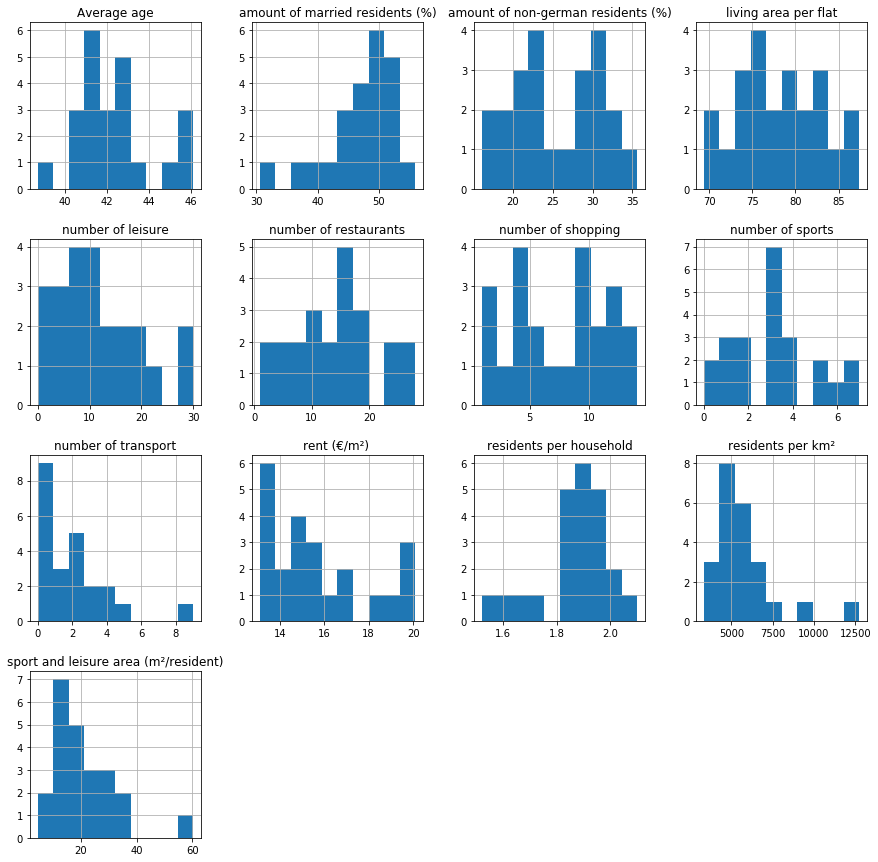

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

#let's check the histograms of the feature to see their distribution
Bouroughs_S_Analysis.hist(figsize=(15,15))

Let's create some regression plots to see the correlation of the different features to the rent

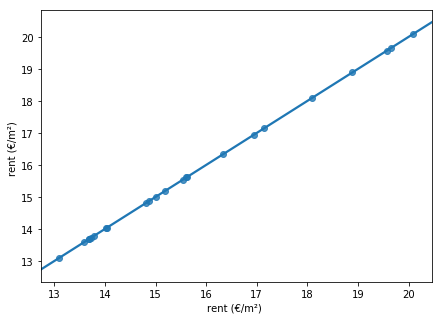

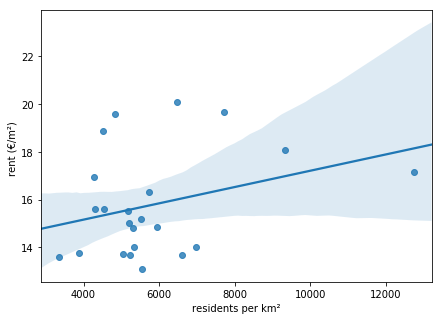

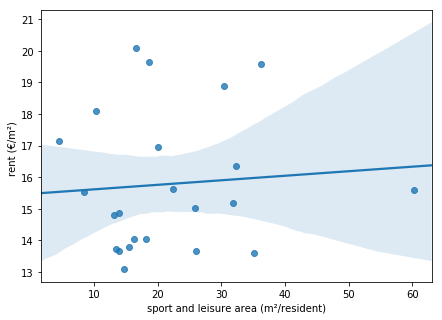

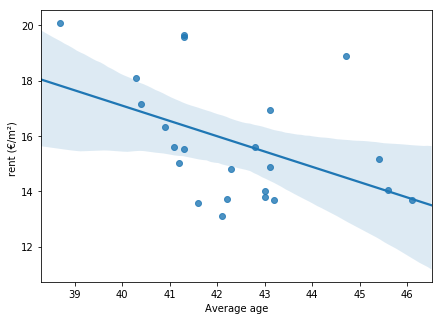

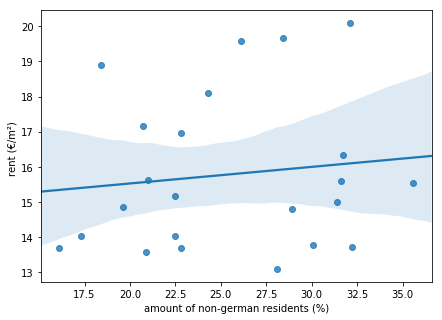

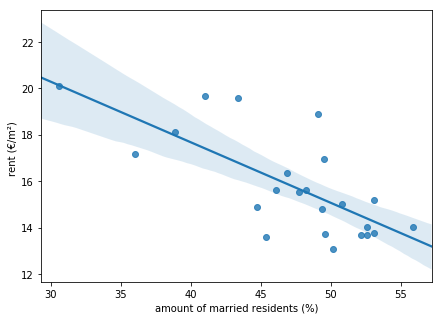

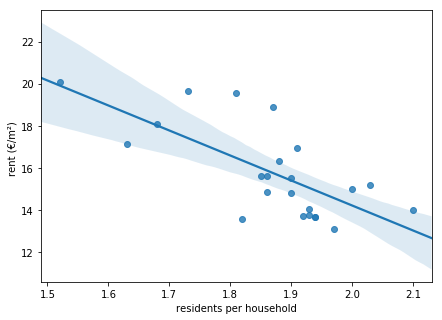

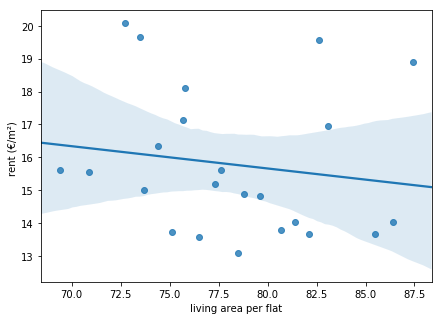

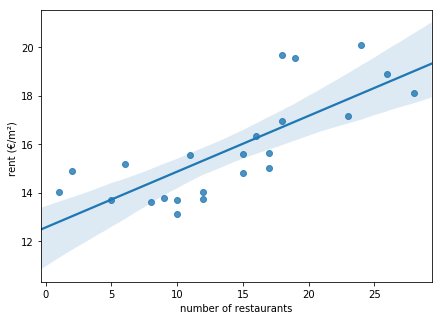

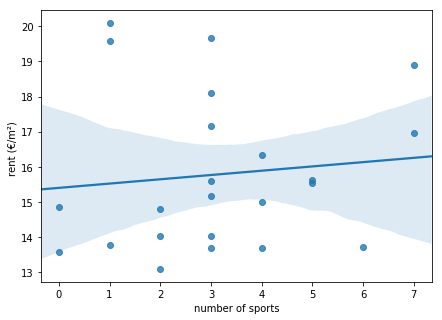

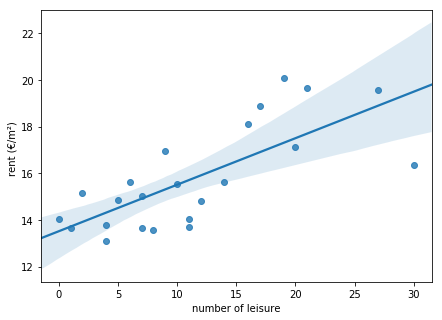

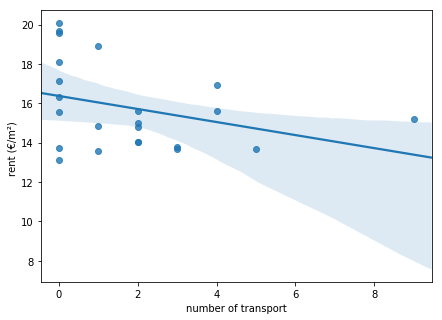

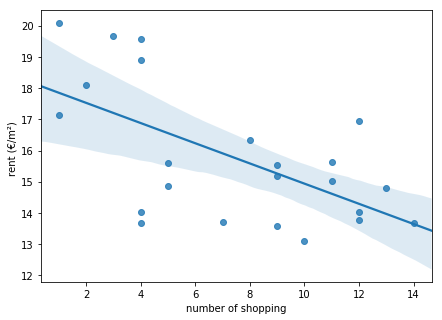

In [36]:
import seaborn as sns

columns_names = Bouroughs_S_Analysis.columns.values.tolist()
i = 0
for col in columns_names:
    i += 1
    plt.figure(i,figsize=(7, 5))
    sns.regplot(x=col, y="rent (€/m²) ", data=Bouroughs_S_Analysis)

By exploring the scatter plot, we can assume following dependencies:

Negative correlation with rent:
1. Amount of married residents
2. residents per household
3. average age


Positive correlation with rent:
1. number of restaurants
2. number of leisure



Now we can calculate the Pearson Correlation between our features and the rent to have a concrete value that describes the correlation

In [23]:
from scipy import stats

#initialize empty list
pearson_coefs = []
p_values = []

# calculate the pearson correlation and p value for every column in our dataframe in relation to the rent column
# and save it to our list 
for col in Bouroughs_S_Analysis.columns.values.tolist():
    pearson_coef, p_value = stats.pearsonr(Bouroughs_S_Analysis[col], Bouroughs_S_Analysis['rent (€/m²) '])
    pearson_coefs.append(pearson_coef)
    p_values.append(p_value)
    
#round the pearson correlation and the p value
pearson_coefs = list(map(lambda x:round(x,3),pearson_coefs))
p_values = list(map(lambda x:round(x,8),p_values))

In [24]:
values = np.array([Bouroughs_S_Analysis.columns.values.tolist(), pearson_coefs, p_values]).transpose()
                  
column_headers = ['feature','Pearson Correlation','p value']

Bouroughs_S_Analysis_stats = pd.DataFrame(data = values, columns = column_headers)

Bouroughs_S_Analysis_stats

,feature,Pearson Correlation,p value
0,rent (€/m²),1.0,0.0
1,residents per km²,0.312,0.14696753
2,sport and leisure area (m²/resident),0.08,0.71755271
3,Average age,-0.461,0.02680288
4,amount of non-german residents (%),0.121,0.58231485
5,amount of married residents (%),-0.723,9.702e-05
6,residents per household,-0.706,0.00016678
7,living area per flat,-0.152,0.48838061
8,number of restaurants,0.771,1.697e-05
9,number of sports,0.11,0.61821963


As we can see from the above data the strongest correlation with a sufficient low p value is between:

Restaurants to Rent = 0.77                                                                                                  
Leisure to Rent = 0.74                                                                                                           
Married residents to Rent = -0.72                                                                                               
Residents to household = -0.71                                                                                                 

With this discovered, we have met out initially set objective. 

For the sake of training though, I will develop a multi liniear regression model to predict rents for other boroughs.

### Modeling

### Multi-Linear Regression without Normalizing

Now we can build a model that can predict the rent of flats when given the number of restaurants and leisure opportunities, the percantage of married residents and the number of residents per household

** Build the model **

In [299]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

#extract the relevant features from our dataframe
lr_features = Bouroughs_S[["number of restaurants","number of leisure","amount of married residents (%)","residents per household"]]
lr_rent = Bouroughs_S["rent (€/m²) "]

#create the linear regression model
regr_1 = linear_model.LinearRegression()

#bring the dataframe into matrices
X = np.asarray(lr_features)
y = np.asarray(lr_rent)

#splitting the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(18, 4) (18,) (5, 4) (5,)


** Train the model and predict the y values for the test set **

In [300]:
regr_1.fit(X_train,y_train)
y_hat= regr_1.predict(X_test)



** Evaluation **

R-squared

In [301]:
from sklearn.metrics import r2_score

r2_score(y_test, y_hat)  

0.4792914841130682

Mean-squared-error

In [302]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_hat)

2.0619349065540895

Plot the actual values against the predicted ones

Text(0,0.5,'Features')

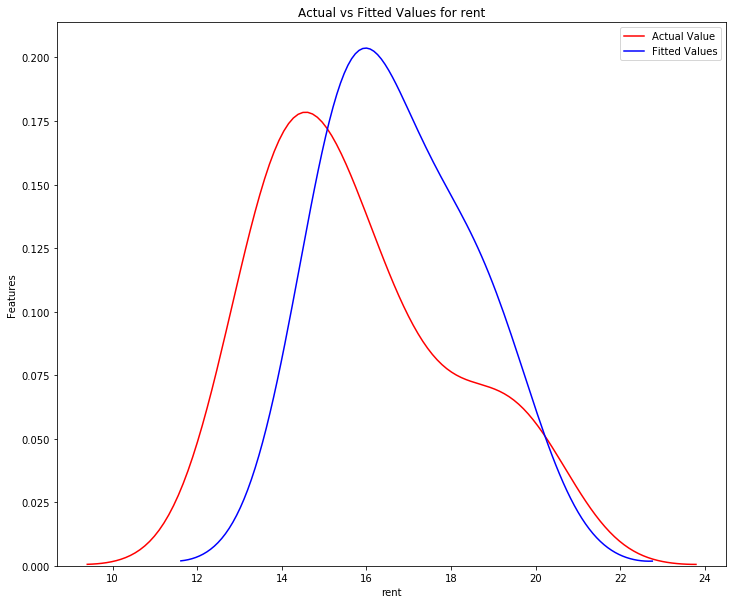

In [303]:
plt.figure(figsize=(12, 10))


ax1 = sns.distplot(Bouroughs_S["rent (€/m²) "], hist=False, color="r", label="Actual Value")
sns.distplot(y_hat, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values for rent')
plt.xlabel('rent')
plt.ylabel('Features')

Since there is so little data and the evaluation scores highly depend on the train/test split, I will use cross validation for a more reliable score

### Multi-Linear Regression with Normalizing

** Normalizing with min-max normalization**

In [240]:
from sklearn.preprocessing import MinMaxScaler

#extract the relevant features from our dataframe
# i'm using .copy() here to not alter the original dataframe when scaling
lr_features = Bouroughs_S[["number of restaurants","number of leisure","amount of married residents (%)","residents per household"]].copy()
lr_rent = Bouroughs_S["rent (€/m²) "]

#normalizing the features with min max normalization

#I didn't use the sklearn function but could have done so
#scaler = MinMaxScaler()
#print(scaler.fit(lr_features))
#print(scaler.data_max_)
#print(scaler.transform(lr_features))

columns = lr_features.columns.values.tolist()
for col in columns:
    col_max = lr_features[col].max()
    col_min = lr_features[col].min()
    for i in range(0,len(lr_features)):
        lr_features.loc[i,col] = (lr_features.loc[i,col] - col_min) / (col_max - col_min)
lr_features.head()

,number of restaurants,number of leisure,amount of married residents (%),residents per household
0,0.555556,1.000000,0.644269,0.620690
1,0.037037,0.166667,0.557312,0.586207
2,0.407407,0.366667,0.869565,0.706897
3,0.925926,0.566667,0.731225,0.603448
4,0.518519,0.400000,0.743083,0.655172


** Build the model **

In [241]:

#create the linear regression model
regr_2 = linear_model.LinearRegression()

#bring the dataframe into matrices
X = np.asarray(lr_features)
y = np.asarray(lr_rent)

#splitting the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(18, 4) (18,) (5, 4) (5,)


** Train the model and predict the y values for the test set **

In [242]:
regr_2.fit(X_train,y_train)
y_hat= regr_2.predict(X_test)


** Evaluation **

R-squared

In [243]:
r2_score(y_test, y_hat)  

0.5576099768829406

Mean-squared-error

In [244]:
mean_squared_error(y_test, y_hat)

1.7080077142118228

Plot the actual values against the predicted ones

Text(0,0.5,'Features')

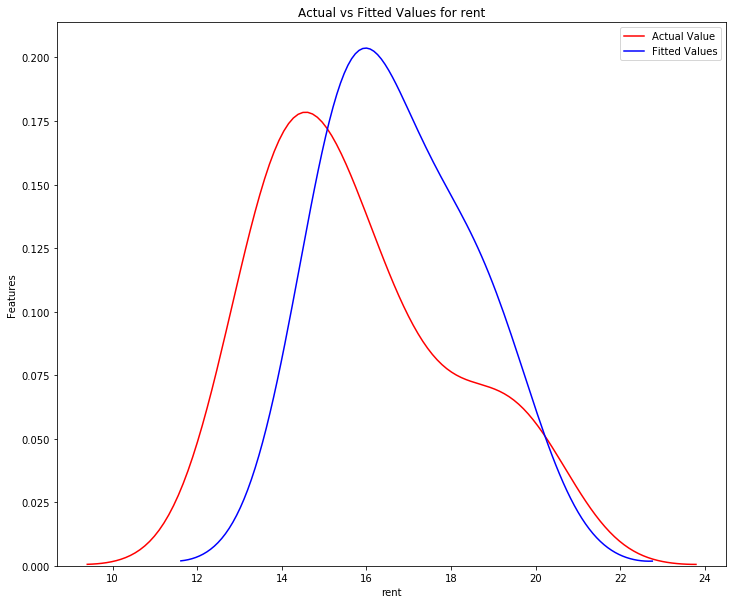

In [304]:
plt.figure(figsize=(12, 10))


ax1 = sns.distplot(Bouroughs_S["rent (€/m²) "], hist=False, color="r", label="Actual Value")
sns.distplot(y_hat, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values for rent')
plt.xlabel('rent')
plt.ylabel('Features')

**Cross validation score**

In [246]:
R_sqaure_cross = cross_val_score(regr_1, lr_features, lr_rent, cv=4)
print(R_sqaure_cross)
print(R_sqaure_cross.mean())

[ 0.26203159  0.67237274  0.7287115  -0.69101005]
0.24302644406745877


Since there is so little data and the performence of the model highly depends on the train/test split, it'd be best to use all the data to train the model

## For further explanations and discussions of the results, please have a look at the report of this project